# UCB for order statistics


In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import statsmodels.api as sm
import pylab 
import itertools
from UCB_discrete import Environment
from UCB_discrete import UCB_os_gau, UCB_os_exp
from collections import defaultdict

%matplotlib inline

## Absolute value of Gaussian with loc zero

In [38]:
num_arms = 3
num_rounds = 50000
num_exper = 50

rewards_env = []

for i in range(num_arms):
    # rewards distribution of arms is gaussian distribution with 
    # mean as 0, variance as i.
    rewards_env.append(Environment(loc = 0, scale = (i + 1) * 0.1))
    
num_sample = 1000000

m_0 = np.median(np.abs(np.random.normal(0,0.1,num_sample)))
m_1 = np.median(np.abs(np.random.normal(0,0.2,num_sample)))
m_2 = np.median(np.abs(np.random.normal(0,0.3,num_sample))) 
print('median of |N(0,1)|: ', m_0)
print('median of |N(0,2)|: ', m_1)
print('median of |N(0,3)|: ', m_2)

medians = [m_0, m_1, m_2]

best_arm = np.argmax(medians)
print('best arm is ', best_arm)

median of |N(0,1)|:  0.06746522133962554
median of |N(0,2)|:  0.1348643792825448
median of |N(0,3)|:  0.2026712387068053
best arm is  2


In [3]:
# use estimate variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env, num_rounds, medians, est_var = True)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_est_var = np.mean(regrets, axis = 0)

In [4]:
# use true variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_gau(rewards_env, num_rounds, medians, est_var = False)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var = np.mean(regrets, axis = 0)

In [32]:
def bound(num_arm, num_round, medians):
    bound = 0
    best_arm = np.argmax(medians)
    for i in range(num_arm):
        delta = medians[best_arm] - medians[i]
        sigma = i + 1
        beta = 32 * np.log(num_round) * sigma * (2 * sigma + delta * np.sqrt(2 * np.log(2)))
        if i != best_arm:
            bound += (np.sqrt(beta) + 8 * sigma * np.sqrt(np.log(num_round))) ** 2 /(np.log(2) * delta**2) 
        bound+= (1+ np.pi**2/3) * delta
    return bound
        
bounds = []
for i in range(1, num_rounds):
    bounds.append(bound(num_arms, i, medians))

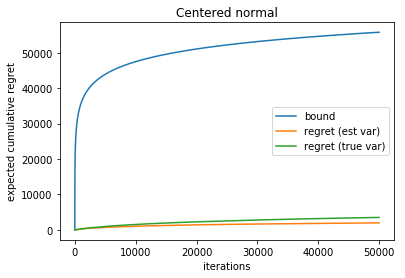

In [33]:
plt.plot(np.asarray(bounds), label = 'bound')
plt.plot(expected_regrets_est_var, label = 'regret (est var)')
plt.plot(expected_regrets_true_var, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Centered normal')
plt.legend()
plt.savefig('ucb_orderstat_centered_normal.png')

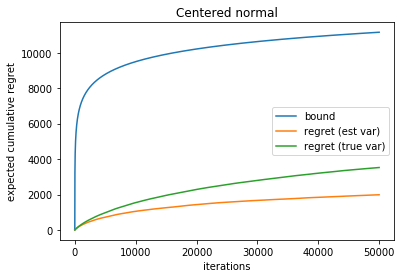

In [35]:
# the bound seems too big, divided by 5, replot

plt.plot(np.asarray(bounds)/5, label = 'bound')
plt.plot(expected_regrets_est_var, label = 'regret (est var)')
plt.plot(expected_regrets_true_var, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Centered normal')
plt.legend()
plt.savefig('ucb_orderstat_centered_normal.png')

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


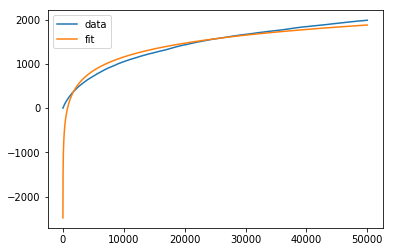

In [29]:
# fit log curve 

from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(b * x) + c

xdata = range(3, num_rounds)
popt, pcov = curve_fit(func, xdata, expected_regrets_est_var)
plt.plot (xdata, expected_regrets_est_var, label = 'data')
plt.plot(xdata, func(xdata, *popt), label = 'fit')
plt.legend()

### For Exponentional Random Variables:

In [21]:
class Exp_Environment():
    """Environment for distribution reward of arms.
    """
    def __init__(self, scale=1.0, size = None):  
        self.scale = scale
        self.size = size
        
    def sample(self):
        # f = 1/scale exp(-x/scale)
        return np.random.exponential(self.scale, self.size)

In [22]:

num_rounds = 50000
num_exper = 50

num_arms = 3
scales = [1, 2, 2.0/3] # lambda = 1, 0.5, 1.5
rewards_env = []
medians = []

for i in range(num_arms):
    rewards_env.append(Exp_Environment(scale = scales[i]))
    medians.append(np.median(np.random.exponential(scale = scales[i], size = num_rounds)))
    
print('medians are: ', medians)

best_arm = np.argmax(medians)

medians are:  [0.6900075458007542, 1.3872814144282128, 0.4641764386374423]


In [23]:
# use estimate variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = True)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_est_var_exp = np.mean(regrets, axis = 0)

In [24]:
# use true variance

regrets = []

for i in range(num_exper):
    agent = UCB_os_exp(rewards_env, num_rounds, medians, est_var = False)
    regrets.append(agent.play())
    
np.asarray(regrets).reshape((num_exper, num_rounds-3))
expected_regrets_true_var_exp = np.mean(regrets, axis = 0)

In [25]:
def bound(num_arm, num_round, medians):
    bound = 0
    best_arm = np.argmax(medians)
    for i in range(num_arm):
        theta = 1.0/scales[i]
        delta = medians[best_arm] - medians[i]
        beta = 32 * np.log(num_round) * (1 + delta * theta)
        if i != best_arm:
            bound += (np.sqrt(beta) + 4 * np.sqrt(2 * np.log(num_round)))**2/ (delta**2 * theta ** 2)
        bound+= (1+ np.pi**2/3) * delta
    return bound
        
bounds = []
for i in range(1, num_rounds):
    bounds.append(bound(num_arms, i, medians))

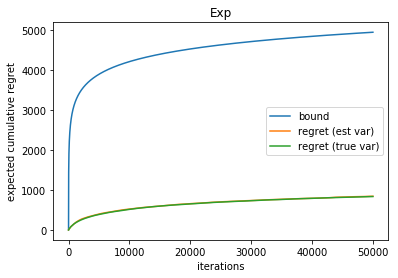

In [26]:
plt.plot(bounds, label = 'bound')
plt.plot(expected_regrets_est_var_exp, label = 'regret (est var)')
plt.plot(expected_regrets_true_var_exp, label = 'regret (true var)')
plt.xlabel('iterations')
plt.ylabel('expected cumulative regret')
plt.title('Exp')
plt.legend()
#plt.savefig('ucb_orderstat_exp_estimate_variance.png')

/home/admin-u6015325/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


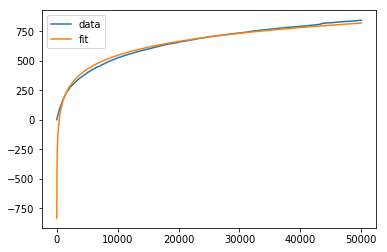

In [30]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.log(b * x) + c

xdata = range(3, num_rounds)
popt, pcov = curve_fit(func, xdata, expected_regrets_est_var_exp)
plt.plot (xdata, expected_regrets_est_var_exp, label = 'data')
plt.plot(xdata, func(xdata, *popt), label = 'fit')
plt.legend()